# Portfolio builder

the objective here is create an optimum porfolio based in ETFs from a desired return minimizing the risk

# 0.1 Manual Parameters

In [518]:
# symbols to evaluate (Yahoo Finance tickers)
symbols = ['^IXIC','^GDAXI','FXI', 'GOLD', 'OIL', 'ZB=F', 'BTC-USD'] 

# Time frame
start_date = '2015-01-01' 
end_date = '2021-12-31'

# Minimum desired return
min_return = 0.1 # annualy (percentage)

# 0.2 libraries

In [506]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize
import warnings

# library parameters
plt.rcParams["figure.figsize"] = (24,6)
warnings.filterwarnings("ignore")

Calculate the days in the time interval

In [507]:
start = datetime.datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.datetime.strptime(end_date, '%Y-%m-%d')
days_held = (end-start).days 

# 1. Get and process data

In [508]:
data = {}
for symbol in symbols:
    data[f'{symbol}'] = yf.download(symbol, start=start_date, end=end_date, progress=False).reset_index()

In [509]:
# Create a unified dataframe to weight in the optimization
close_data = pd.DataFrame()
for symbol in symbols:
    df = data[f'{symbol}']
    initial_value = df['Close'][df.first_valid_index()]
    df[f'{symbol}'] = df['Close']/initial_value

    # fixing the problem when an asset have less data
    if len(close_data.columns) == 0:
        close_data = df[['Date', f'{symbol}']]
    else:
        close_data = pd.merge(close_data, df[['Date', f'{symbol}']], on= 'Date', how='outer')
        
# when the data has empty values we fill NaN's with the previous value       
close_data = close_data.sort_values(by='Date').reset_index(drop=True)
for index in range(len(close_data)):
    if np.isnan(sum(close_data.loc[index, symbols])):
        for symbol in symbols:
            if np.isnan(close_data.loc[index, symbol]):
                if index-1 > 0:
                    close_data.loc[index, symbol] = close_data.loc[index-1, symbol]
                else:
                    # if there is no previous value set to 1
                    close_data.loc[index, symbol] = 1

close_data


,Date,^IXIC,^GDAXI,FXI,GOLD,OIL,ZB=F,BTC-USD
0,2015-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.002492
2,2015-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.894456
3,2015-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.840719
4,2015-01-05,0.984294,0.970140,0.996401,0.999083,0.956031,1.010095,0.873428
...,...,...,...,...,...,...,...,...
2552,2021-12-27,3.357711,1.621678,0.876440,1.687443,0.949980,1.104811,161.147431
2553,2021-12-28,3.338767,1.634833,0.866363,1.683776,0.949576,1.104167,151.436780
2554,2021-12-29,3.335488,1.623419,0.856286,1.686526,0.956031,1.095361,147.795894
2555,2021-12-30,3.330271,1.626759,0.887476,1.725023,0.956031,1.098797,150.129757


# 2. Calculate return and risk

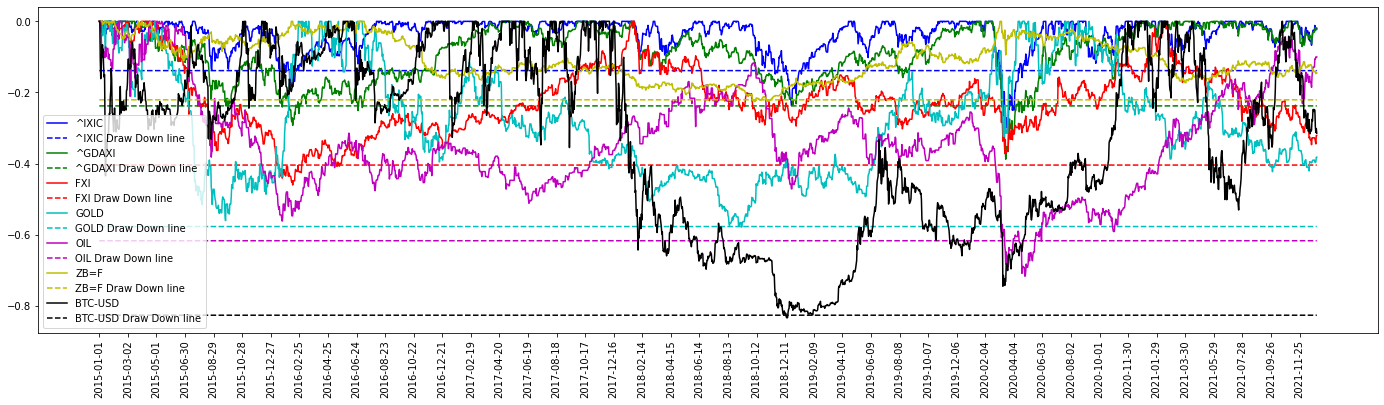

In [510]:
def measure_return(df):
    # Calculate return
    finish = df['Close'][df.last_valid_index()]
    start = df['Close'][df.first_valid_index()]
    return (finish - start)/start

def compute_drawdown(df):
    # Calculate drawdown
    global_high = 0
    for index in range(len(df)):
        if global_high < float(df.loc[index, 'Close']):
            global_high = float(df.loc[index, 'Close'])
            draw_down = 0
        else:
            try:
                draw_down = (global_high - float(df.loc[index, 'Close']))/global_high   
            except:
                print(float(df.loc[index, 'Close']))
                draw_down = (global_high - float(df.loc[index, 'Close']))/global_high   

        df.loc[index, 'Draw Down'] = -draw_down

    return df

def measure_risk(df):
    mean = np.mean(df[df['Draw Down'] != 0]['Draw Down'])
    std = -np.std(df[df['Draw Down'] != 0]['Draw Down'])
    risk = abs(mean + std*2)
    return risk


colors =['b','g','r','c','m','y','k','w']
results = []
for symbol in symbols:
    # calculate for every asset
    df = close_data[['Date', f'{symbol}']]
    df.columns = ['Date', 'Close']
    df = compute_drawdown(df)

    results.append([symbol, measure_return(df), measure_risk(df)])

    # Plot the drawd downs
    risk = measure_risk(df)
    plt.plot(df['Date'], df['Draw Down'], label=f'{symbol}', color = colors[symbols.index(symbol)])
    plt.plot(df['Date'], [-risk for i in range(len(df))] , label = f'{symbol} Draw Down line', 
                linestyle = '--' , color = colors[symbols.index(symbol)])

plt.legend()
plt.xticks(df['Date'][::60],rotation = 90, fontsize = 10)
plt.show()

In [511]:
# Convert results to dataframe
output = pd.DataFrame(np.array(results), columns=['Asset', 'Return', 'Risk'])

# Anualizing the results
output['Anualized Return'] = (1+output['Return'].astype(float))**(365/days_held)-1
output

,Asset,Return,Risk,Anualized Return
0,^IXIC,2.3302712347607413,0.1386045923106735,0.187437
1,^GDAXI,0.6267587110979365,0.23782188261891501,0.071957
2,FXI,-0.11252395855012953,0.4042375729238811,-0.016902
3,GOLD,0.725022910911258,0.5771536503733523,0.080972
4,OIL,-0.04396934700817878,0.617134832341018,-0.006401
5,ZB=F,0.09879725085910662,0.22073578002855898,0.013545
6,BTC-USD,146.35590679935763,0.8265416545227875,1.040072


# 3. Calculate the optimal portfolio

Minimize the Draw Down.

In [565]:
# calculate the 95% confidence interval of the draw_down
def objective_function(weights, close_data=close_data):
    # compute the weighted closes
    matrix_assets = np.matrix(close_data[symbols].values)
    matrix_weights = np.matrix(weights).T
    matrix_portfolio = matrix_assets*matrix_weights

    # save the portfolio returns as df
    df = pd.DataFrame()
    df['Date'] = close_data['Date']
    df['Close'] = matrix_portfolio

    return measure_risk(compute_drawdown(df))

# Constraint of weights sum equal to 1
def equal_one(weights):
    con = sum(weights) - 1  
    return con 

# constraint of minimum expected return
def minimum_return(weights, minimum = min_return):
    # compute the weighted closes
    matrix_assets = np.matrix(close_data[symbols].values)
    matrix_weights = np.matrix(weights).T
    matrix_portfolio = matrix_assets*matrix_weights

    # save the portfolio returns as df
    df = pd.DataFrame()
    df['Date'] = close_data['Date']
    df['Close'] = matrix_portfolio

    profit = df['Close'][df.last_valid_index()]-1
    minimum_return = (1+minimum)**(days_held/365)-1

    return profit - minimum_return

#set up the constraints for weights
con = ({'type':'eq', 'fun':equal_one},
       {'type':'ineq', 'fun':minimum_return})

# set up the boundaries for weights
bound = (0, 1)
bnds = tuple([bound for _ in symbols])

# set initial weights
weights = [1/len(symbols) for _ in range(len(symbols))]
weights = np.array(weights)

# Minimize
sol = minimize(objective_function, weights, method = 'SLSQP', bounds = bnds, constraints = con)
print(sol)

     fun: 0.07307794394754619
     jac: array([ 0.01767649,  0.02150943,  0.02506132,  0.00369469,  0.04278945,
       -0.01088339,  1.23177201])
 message: 'Optimization terminated successfully'
    nfev: 74
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([3.81006576e-01, 0.00000000e+00, 2.04660941e-12, 0.00000000e+00,
       0.00000000e+00, 6.18991903e-01, 1.52136165e-06])


In [513]:
expected_return = minimum_return(sol['x'])+(1+min_return)**(days_held/365)-1
risk = sol['fun']
anualized_return = (1+expected_return)**(365/days_held)-1

output.loc[len(output)] = np.array(['Portfolio', expected_return, risk, anualized_return])
roudable_fields =['Return', 'Risk', 'Anualized Return']
output[roudable_fields] = (output[roudable_fields].astype(float)*100).round(1)
output[roudable_fields] = output[roudable_fields].astype(str) + "%"
output

,Asset,Return,Risk,Anualized Return
0,^IXIC,233.0%,13.9%,18.7%
1,^GDAXI,62.7%,23.8%,7.2%
2,FXI,-11.3%,40.4%,-1.7%
3,GOLD,72.5%,57.7%,8.1%
4,OIL,-4.4%,61.7%,-0.6%
5,ZB=F,9.9%,22.1%,1.4%
6,BTC-USD,14635.6%,82.7%,104.0%
7,Portfolio,94.9%,7.3%,10.0%


Portfolio composition

In [514]:
for symbol in symbols:
    weight = round(sol["x"][symbols.index(symbol)]*100,2)
    print(f'weight of {symbol}: {weight}%')

weight of ^IXIC: 38.1%
weight of ^GDAXI: 0.0%
weight of FXI: 0.0%
weight of GOLD: 0.0%
weight of OIL: 0.0%
weight of ZB=F: 61.9%
weight of BTC-USD: 0.0%


# 4. Portfolio analysis

We have created a portfolio based on minimum drawdown, but let's check their variance and performance when we add more assets

First, look at the draw down of the portfolio

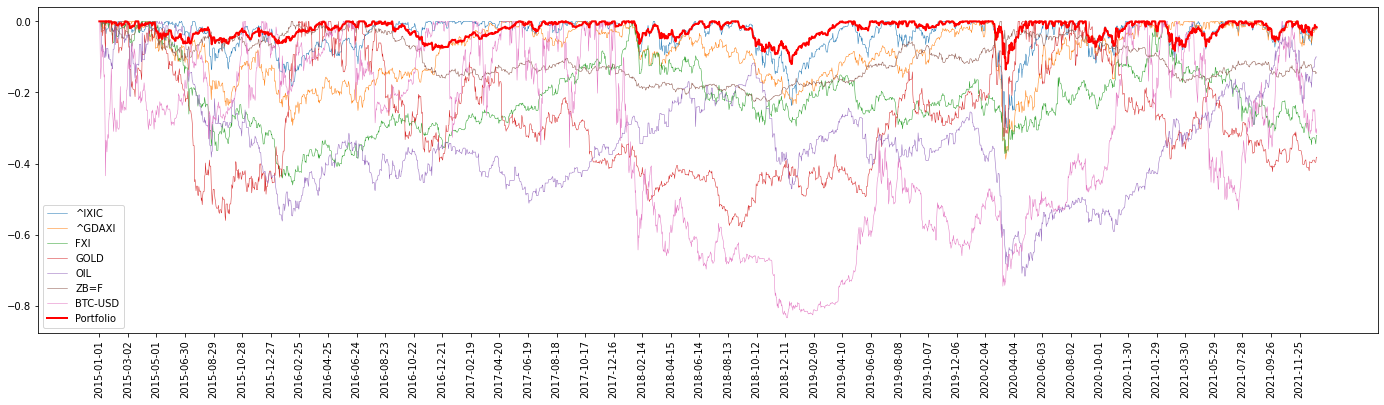

In [515]:
#plot the asset benchmark
for symbol in symbols:
    # calculate for every asset
    df = close_data[['Date', f'{symbol}']]
    df.columns = ['Date', 'Close']
    df = compute_drawdown(df)

    # Plot the drawd downs
    risk = measure_risk(df)
    plt.plot(df['Date'], df['Draw Down'], label=f'{symbol}', linewidth= 0.5)


#recover the solution
matrix_assets = np.matrix(close_data[symbols].values)
matrix_weights = np.matrix(sol['x']).T
matrix_portfolio = matrix_assets*matrix_weights

# save the portfolio returns as df
df = pd.DataFrame()
df['Date'] = close_data['Date']
df['Close'] = matrix_portfolio
portfolio = compute_drawdown(df)

# Plot and highlight the porfolio draw down
plt.plot(portfolio['Date'], portfolio['Draw Down'], label='Portfolio', linewidth= 2, color='red')

plt.legend()
plt.xticks(portfolio['Date'][::60],rotation = 90, fontsize = 10)
plt.show()

cheking the portfolio's return

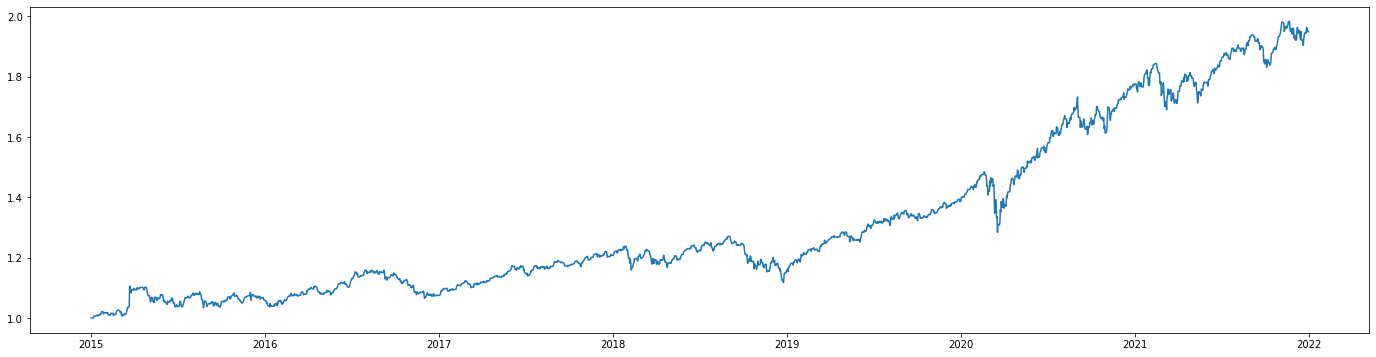

In [516]:
plt.plot(portfolio['Date'], portfolio['Close'])
plt.show()

Checking the portfolio variance and compare with assets

In [517]:
print(f"Portfolio Variance: {np.cov(portfolio['Close'])}")
for symbol in symbols:
    print(f"{symbol} Variance: {np.cov(close_data[f'{symbol}'])}")

Portfolio Variance: 0.07475562143594289
^IXIC Variance: 0.4525223197201418
^GDAXI Variance: 0.027887703920538506
FXI Variance: 0.013035018239748685
GOLD Variance: 0.22900253986801772
OIL Variance: 0.021705501213257764
ZB=F Variance: 0.005263157140246651
BTC-USD Variance: 2557.6328826000913
